In [2]:
# import modules
import numpy as np
import pandas as pd
from scipy import stats
 
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)


In [3]:
# read in the data to dataframe called ames
ames = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/Ames_house_prices.csv", na_values=['?'])
# replace the ? in the data with NaN for missing values
ames.replace([' ?'],np.nan)
# show information about the dataframe
#ames.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


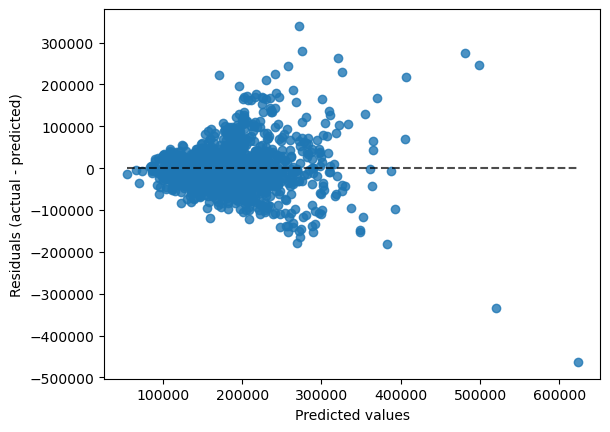

In [4]:
# In sklearn we first need to create a model object 
# and here it is a linear regression
ames_model= LinearRegression()
# note below that the x needs to be a two dimensional array so we 
# need the double brackets here
ames_x=ames[['GrLivArea']]
# y needs to be a one dimensional array so single brackets work
ames_y=ames['SalePrice']
ames_model.fit(ames_x, ames_y)

ames_y_hat = ames_model.predict(ames_x)
# below makes a 
display = PredictionErrorDisplay(y_true=ames_y, y_pred=ames_y_hat)
display.plot()
plt.show()

You may recall that the graph above was indicative of non-constant variability.
The consequence of this is that the standard errors, and consequent p-values
and confidence intervals are not accurate.  

One possible remedy for this is a log transformation.  

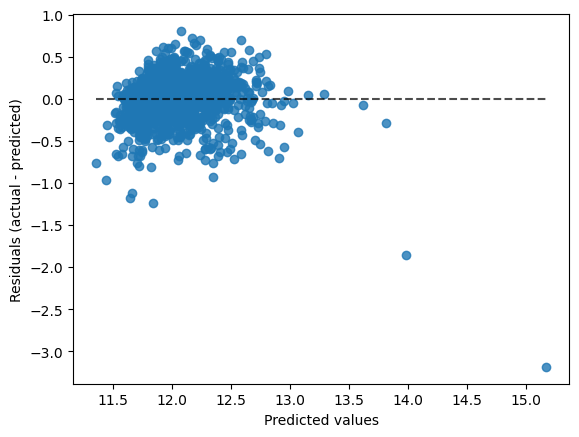

In [5]:

model1=LinearRegression()

X = ames[['LotArea', 'GrLivArea', 'BsmtFinSF1']]
y = np.log(ames['SalePrice'])

# fit the linear regression to the data.
model1.fit(X,y)

# make the residual vs fitted plot
y_hat = model1.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat)
display.plot()
plt.show()

The variability in the residuals from the plot above is noticeably better, that is, 
more constant.

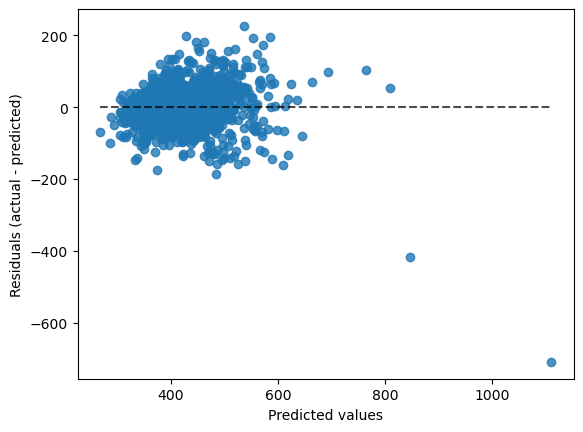

In [6]:

model1=LinearRegression()

X = ames[['LotArea', 'GrLivArea', 'BsmtFinSF1']]
y = np.sqrt(ames['SalePrice'])

# fit the linear regression to the data.
model1.fit(X,y)

# make the residual vs fitted plot
y_hat = model1.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat)
display.plot()
plt.show()

The *sqrt* transformation is very similar to the *log* transformation generally
and appears that way here.

Though it both cases we have some outiers that are likely influential points
because of their leverages.  

A couple of notes:

1. The *log* and *sqrt* transformations often happen when you have large variability in your target which can lead to heteroskedasticity.

2. Both the *log* and the *sqrt* transformation require positive values, so zeros or negative values are a headache.  If we only have zero's then it is possible to add a 1 to the response but that then causes some interpretability issues.

3. Speaking of interpretability issues, transformations often make interpretations of coefficients harder.

4. Some other transformation that can work are $1/Y$  when residual variation is increasing in a way that is quadratic, powers of $Y$ when the residual variation is decreasing which is rarer generally.


#### Transformation of Predictors
It is possible to do transformation of the predictors as well which 
we have seen with the addition of quadratic terms as predictors.
The need to use transformation can be useful particularly if 
you are using a linear regression.  Let's look at an example.

We continue with using log(SalePrice) for the target/response/dependent variable.

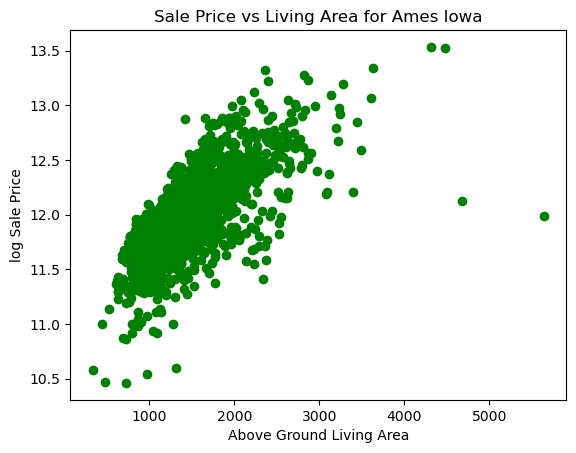

In [7]:
plt.scatter( ames['GrLivArea'],np.log(ames['SalePrice']), color="green")

# Add labels and title
plt.xlabel('Above Ground Living Area')
plt.ylabel('log Sale Price')
plt.title('Sale Price vs Living Area for Ames Iowa')

# Show the plot
plt.show()

Given that there is a somewhat curved relationship with these data, 
we will try a log transormation of the predictor here.

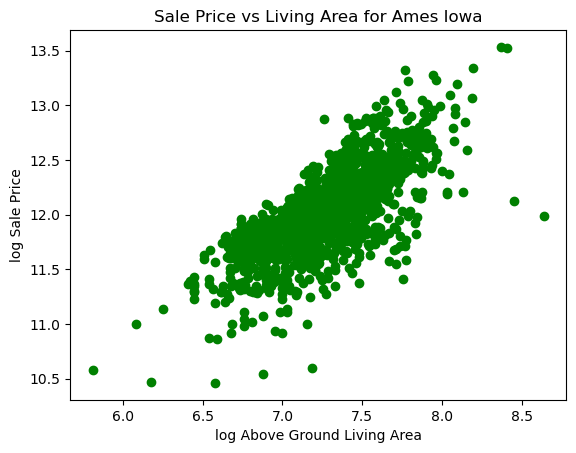

In [8]:
plt.scatter( np.log(ames['GrLivArea']),np.log(ames['SalePrice']), color="green")

# Add labels and title
plt.xlabel('log Above Ground Living Area')
plt.ylabel('log Sale Price')
plt.title('Sale Price vs Living Area for Ames Iowa')

# Show the plot
plt.show()

That looks better though there might still be some curvature to the plot.

Let's look at some of the other predictors.

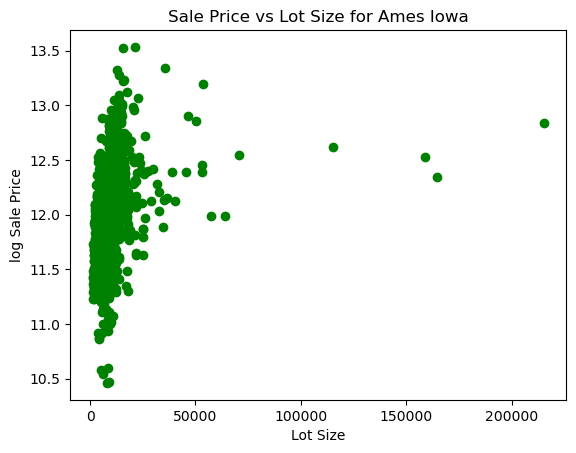

In [9]:
plt.scatter( ames['LotArea'],np.log(ames['SalePrice']), color="green")

# Add labels and title
plt.xlabel('Lot Size')
plt.ylabel('log Sale Price')
plt.title('Sale Price vs Lot Size for Ames Iowa')

# Show the plot
plt.show()

Hard to get much out of this plot except that there are some really huge
lot sizes in Ames, IA.  As a note, about 45000 square feet is an acre so
that the largest of these lots is about 4 acres.

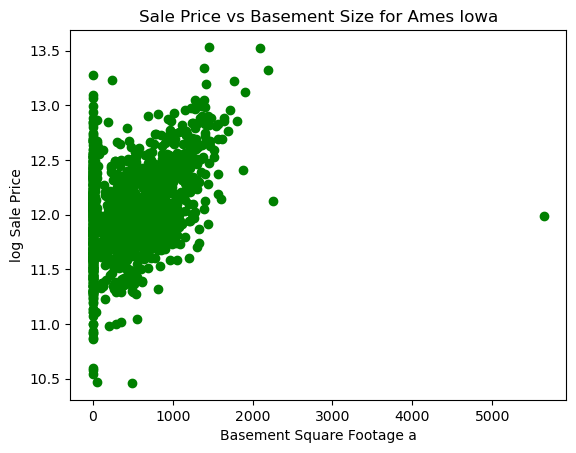

In [10]:
plt.scatter( ames['BsmtFinSF1'],np.log(ames['SalePrice']), color="green")

# Add labels and title
plt.xlabel('Basement Square Footage a')
plt.ylabel('log Sale Price')
plt.title('Sale Price vs Basement Size for Ames Iowa')

# Show the plot
plt.show()


While this plot is not particularly nice, there is a linear component to it.



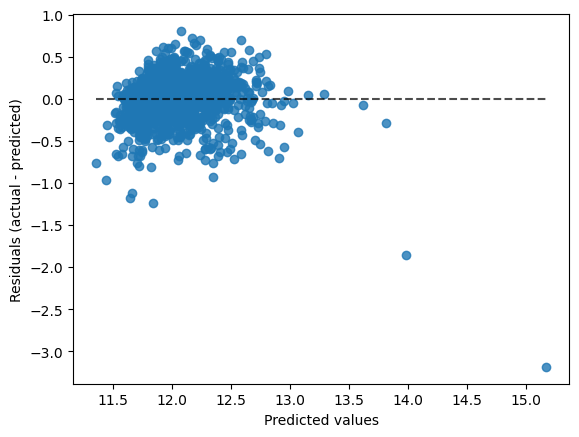

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     583.9
Date:                Mon, 17 Feb 2025   Prob (F-statistic):          4.08e-249
Time:                        09:19:46   Log-Likelihood:                -154.73
No. Observations:                1460   AIC:                             317.5
Df Residuals:                    1456   BIC:                             338.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1778      0.022    513.628      0.0

In [11]:
model2=LinearRegression()
ames['logLotArea']=np.log(ames['LotArea'])

X = ames[['LotArea', 'GrLivArea', 'BsmtFinSF1']]
y = np.log(ames['SalePrice'])

# fit the linear regression to the data.
model2.fit(X,y)

# make the residual vs fitted plot
y_hat = model2.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat)
display.plot()
plt.show()

x2 = sm.add_constant(X)

#fit linear regression model
model2a = sm.OLS(y, x2).fit()

#view model summary
print(model2a.summary())


The above plot looks pretty good with the exception of the outliers and the fact that we have a transformed response.  The latter means that our interpretations of the coefficients are all going to look like _For each additional square foot of above ground living area (GrLivArea), we predict that the log sale price of a home will increase by 0.0005 assuming that lot area and finished basement square footage remain the same_.  Somewhat unsatisfying and difficult to explain to a client or a realtor or whomever.

We are still able to get predicted values for houses by taking the predicted value from our regression equation and exponentiating it, that is, taking the inverse function of the log.

In [12]:
y_hat = model2.predict(X)
preds=np.exp(y_hat)
print(np.round(preds,2))

[192664.37 163789.95 192128.55 ... 240556.93 124192.7  158599.78]


### Generalized Additive Models

Generalized Additive Models or GAMs are tools that can add flexibility to modelling.

The general form of a GAM is 
$$y= \beta_0+ f_1(x_1)+f_2(x_2)+f_3(x_3)+ ...$$

where the different functions for $f_i$ can be anything.  For example, $f_1$ could be a linear function while
$f_2$ could be a spline and $f_3$ could be local.  It is also possible to have interaction terms between
predictors and effectively make a surface beween the two. 
They are additive meaning the effect of term is added to the next.  

One consequence of GAMs is that there is not much need to consider transformations of
predictors/features since the model has such flexibility.  For the responses/targets,
there is also less concern though we are still concerned with constant variability. 

But sad news, the *pygam* library in Python does not currently work with the newest version of Python.

Here's an example of how *pygam* works that looks at splines and GAMs
[<https://harvard-iacs.github.io/2021-CS109B/lectures/lecture05.5/notebook1/>]




That's a bummer, not least because I had planned a bunch of ''lovely'' tasks for you using GAMs. 

### Centering predictors

One of the annoying things about linear regression is the interpretation of
the y-intercept and that often is not meaningful.  A way to change that is
to 're-center' each of the predictors to their mean (or some other value
that might be meaningful ).  We do this my substracting the mean from each 
observation so that a 0 in the data represents the mean of a particular predictor.

Recall this regression from the blue jay data

In [13]:
# read in the blue jay data
bluejay = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/BlueJays.csv", na_values=['NA'])
# remove rows with missing data
bluejay.dropna(inplace=True)
bluejay.head()

,Unnamed: 0,BirdID,KnownSex,BillDepth,BillWidth,BillLength,Head,Mass,Skull,Sex
0,1,0000-00000,M,8.26,9.21,25.92,56.58,73.30,30.66,1
1,2,1142-05901,M,8.54,8.76,24.99,56.36,75.10,31.38,1
2,3,1142-05905,M,8.39,8.78,26.07,57.32,70.25,31.25,1
3,4,1142-05907,F,7.78,9.30,23.48,53.77,65.50,30.29,0
4,5,1142-05909,M,8.71,9.84,25.47,57.32,74.90,31.85,1


In [14]:
# below we build a multiple regression model with three predictors
#  Predictors here are Head, BillDepth, and BillLength
# Our target variable will be the Mass of the blue jay 

X = bluejay[['Head', 'BillDepth', 'BillLength']]  
y = bluejay['Mass']  


# Create a linear regression model
blue_model = LinearRegression()

# Fit the model on the  data
blue_model.fit(X, y)

# Make predictions on the  data
y_hat = blue_model.predict(X)


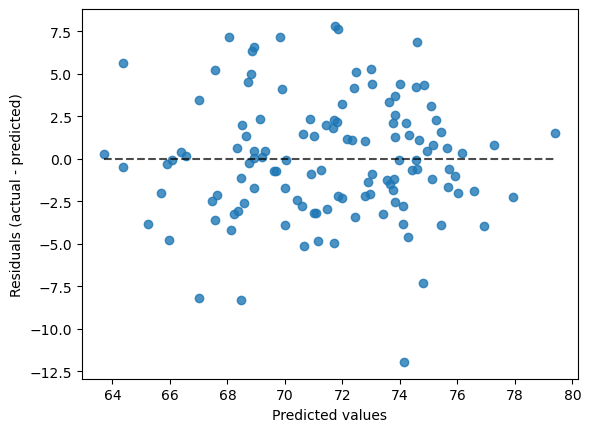

In [15]:
# below makes a residual plot
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat)
display.plot()
plt.show()

In [16]:
# for this particular model formulation we need to add a 
# column of 1's to the feature array
#add constant to predictor variables
x2 = sm.add_constant(X)

#fit linear regression model using OLS
blue_model2 = sm.OLS(y, x2).fit()

#view model summary
print(blue_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mass   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     34.16
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           5.35e-16
Time:                        09:21:22   Log-Likelihood:                -327.91
No. Observations:                 123   AIC:                             663.8
Df Residuals:                     119   BIC:                             675.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.2001     12.237     -4.102      0.0

Recall that we interpreted the $-50.2001$ in the output above as 
_Our y-intercept is estimated to be $-50.2$ which means that for a blue jay with a Bill depth of 0 mm, a bill length of 0 mm and a head size of 0mm, we would predict that their body mass would be -50.2 g._

Next we re-center our predictors.

In [17]:
# center each of our predictors
bluejay['Head_c']=bluejay['Head']-np.mean(bluejay['Head'])
bluejay['BillDepth_c']=bluejay['BillDepth']-np.mean(bluejay['BillDepth'])
bluejay['BillLength_c']=bluejay['BillLength']-np.mean(bluejay['BillLength'])

X_c=bluejay[['Head_c','BillDepth_c','BillLength_c']]

In [18]:
# Create a linear regression model
blue_model2 = LinearRegression()

# Fit the model on the  data
blue_model2.fit(X_c, y)

# Make predictions on the  data
y_hat_c = blue_model2.predict(X_c)

In [19]:
# for this particular model formulation we need to add a 
# column of 1's to the feature array
#add constant to predictor variables
x2_c = sm.add_constant(X_c)

#fit linear regression model using OLS
blue_model2_c = sm.OLS(y, x2_c).fit()

#view model summary
print(blue_model2_c.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mass   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     34.16
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           5.35e-16
Time:                        09:21:39   Log-Likelihood:                -327.91
No. Observations:                 123   AIC:                             663.8
Df Residuals:                     119   BIC:                             675.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           71.5574      0.319    224.320   

Now compare the coefficients from *blue_model2_c* and *blue_model2*.  The only difference
is the estimated y-intercept which is now $71.5574$.  The other coefficients remain unchanged as does their interpretation.

We now interpret $\hat{\beta}_0 = 71.5574$ as the predicted value of a blue jay's
mass when the other predictors are at their mean.   

Just to confirm that we get the same values for prediction for this model, we'll look at the differences in the predicted values.

In [20]:
print(y_hat-y_hat_c)

[ 0.00000000e+00  1.42108547e-14  2.84217094e-14  1.42108547e-14
  1.42108547e-14 -1.42108547e-14  1.42108547e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.42108547e-14  0.00000000e+00
  1.42108547e-14  1.42108547e-14  2.84217094e-14  0.00000000e+00
  2.84217094e-14 -1.42108547e-14  1.42108547e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.42108547e-14
  1.42108547e-14  0.00000000e+00  1.42108547e-14  0.00000000e+00
  4.26325641e-14  1.42108547e-14  1.42108547e-14  1.42108547e-14
  1.42108547e-14  1.42108547e-14  0.00000000e+00  1.42108547e-14
 -1.42108547e-14 -1.42108547e-14  2.84217094e-14 -1.42108547e-14
  1.42108547e-14 -1.42108547e-14  1.42108547e-14 -1.42108547e-14
  1.42108547e-14  0.00000000e+00  2.84217094e-14  2.84217094e-14
 -1.42108547e-14  0.00000000e+00 -1.42108547e-14 -1.42108547e-14
  1.42108547e-14  0.00000000e+00 -1.42108547e-14  0.00000000e+00
  1.42108547e-14  2.84217094e-14 -1.42108547e-14  0.00000000e+00
  1.42108547e-14  2.84217

So what we have above is values that are effectively zero since $10^{-14}$ is really small.

### Tasks

1. Open the penguins data, recenter the predictors flipper_length_mm, bill_depth_mm and run a regression predicting body mass.  Interpret the coefficients.


In [39]:
penquins = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/penguins.csv")
# remove rows with missing data
penquins.dropna(inplace=True)
penquins.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [40]:
# get dummies for species column
penquins = pd.get_dummies(penquins, columns=['species'])
penquins.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,species_Adelie,species_Chinstrap,species_Gentoo
0,Torgersen,39.1,18.7,181.0,3750.0,male,2007,True,False,False
1,Torgersen,39.5,17.4,186.0,3800.0,female,2007,True,False,False
2,Torgersen,40.3,18.0,195.0,3250.0,female,2007,True,False,False
4,Torgersen,36.7,19.3,193.0,3450.0,female,2007,True,False,False
5,Torgersen,39.3,20.6,190.0,3650.0,male,2007,True,False,False


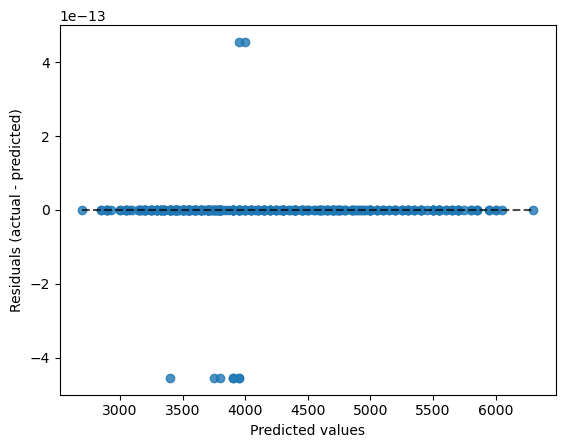

In [41]:
# add numerical values to species_Adelie and species_Chinstrap
penquins['Adelie'] = penquins['species_Adelie']
penquins['Chinstrap'] = penquins['species_Chinstrap']
# center each of our predictors
penquins['body_mass_c']=penquins['body_mass_g']-np.mean(penquins['body_mass_g'])
penquins['flipper_length_c']=penquins['flipper_length_mm']-np.mean(penquins['flipper_length_mm'])
penquins['bill_length_c']=penquins['bill_length_mm']-np.mean(penquins['bill_length_mm'])

# run the regression
model3=LinearRegression()
X = penquins[['flipper_length_c','bill_length_c','body_mass_c']]
y = penquins['body_mass_g']

# fit the linear regression to the data.
model3.fit(X,y)

# make the residual vs fitted plot
y_hat3 = model3.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat3)
display.plot()
plt.show()


2. We don't need to recenter an indicator variable but their interpretation changes a bit.  Rerun the regression in Task 1 above but add the indicators for 'Gentoo' and 'Chinstrap' species of penguins.  Interpret the coefficients that you get. 

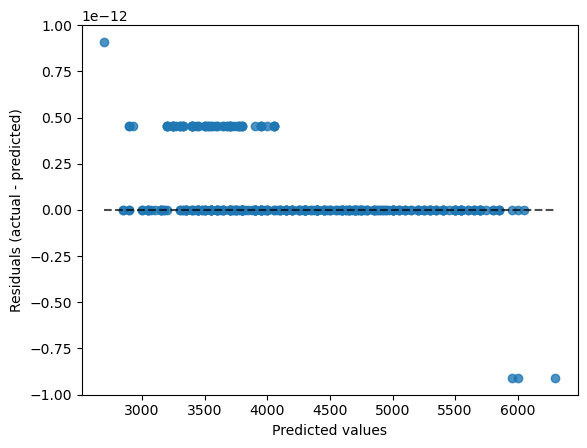

In [42]:
# run the regression
model4=LinearRegression()
X = penquins[['flipper_length_c','bill_length_c','body_mass_c','species_Adelie','species_Chinstrap']]
y = penquins['body_mass_g']

# fit the linear regression to the data.
model4.fit(X,y)

# make the residual vs fitted plot
y_hat4 = model4.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat4)
display.plot()
plt.show()